In [254]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Board Games Rank Prediction

# Libraries and dependencies

In [221]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Dataset
Original dataset comes from [Kaggle](https://www.kaggle.com/datasets/joebeachcapital/board-games).
Dataset used in the project consists of two merged files: 
- File *details* containing basic information about board games available on the site,
- File *ratings* containing games' ratings

Data has been gathered on Feb 2024.

In [222]:
df_details = pd.read_csv("Data/details.csv", 
                         index_col="id"
                        )
df_ratings = pd.read_csv("Data/ratings.csv", 
                        index_col="id",
                         usecols=["id", "year", "rank", "average", "bayes_average", "users_rated"]
                        )
df = pd.merge(df_details, df_ratings, how="left", on="id")

In [223]:
df.head()

,num,primary,description,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,...,boardgamepublisher,owned,trading,wanting,wishing,year,rank,average,bayes_average,users_rated
id,,,,,,,,,,,,,,,,,,,,,
30549,0,Pandemic,"In Pandemic, several virulent diseases have br...",2008,2,4,45,45,45,8,...,"['Z-Man Games', 'Albi', 'Asmodee', 'Asmodee It...",168364,2508,625,9344,2008,106,7.59,7.487,108975
822,1,Carcassonne,Carcassonne is a tile-placement game in which ...,2000,2,5,45,30,45,7,...,"['Hans im Glück', '999 Games', 'Albi', 'Bard C...",161299,1716,582,7383,2000,190,7.42,7.309,108738
13,2,Catan,"In CATAN (formerly The Settlers of Catan), pla...",1995,3,4,120,60,120,10,...,"['KOSMOS', '999 Games', 'Albi', 'Asmodee', 'As...",167733,2018,485,5890,1995,429,7.14,6.970,108024
68448,3,7 Wonders,You are the leader of one of the 7 great citie...,2010,2,7,30,30,30,10,...,"['Repos Production', 'ADC Blackfire Entertainm...",120466,1567,1010,12105,2010,73,7.74,7.634,89982
36218,4,Dominion,"&quot;You are a monarch, like your parents bef...",2008,2,4,30,30,30,13,...,"['Rio Grande Games', '999 Games', 'Albi', 'Bar...",106956,2009,655,8621,2008,104,7.61,7.499,81561


In [224]:
df.shape

(21631, 27)

In [225]:
df.describe()

,num,yearpublished,minplayers,maxplayers,playingtime,minplaytime,maxplaytime,minage,owned,trading,wanting,wishing,year,rank,average,bayes_average,users_rated
count,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000
mean,10815.000000,1986.094910,2.007027,5.709491,90.509177,63.647774,90.509177,9.611391,1487.924553,43.585965,42.030373,233.655587,1988.101290,10879.522352,6.417249,5.683664,874.548518
std,6244.476172,210.042496,0.688957,15.102385,534.826511,447.213702,534.826511,3.640562,5395.077773,102.410851,117.940355,800.657809,190.115056,6311.917913,0.929345,0.366096,3695.946026
min,0.000000,-3500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.040000,0.000000,30.000000
25%,5407.500000,2001.000000,2.000000,4.000000,25.000000,20.000000,25.000000,8.000000,150.000000,5.000000,3.000000,14.000000,2001.000000,5408.500000,5.830000,5.510000,57.000000
50%,10815.000000,2011.000000,2.000000,4.000000,45.000000,30.000000,45.000000,10.000000,322.000000,13.000000,9.000000,39.000000,2011.000000,10839.000000,6.450000,5.546000,124.000000
75%,16222.500000,2017.000000,2.000000,6.000000,90.000000,60.000000,90.000000,12.000000,903.500000,38.000000,29.000000,131.000000,2017.000000,16356.500000,7.040000,5.678000,397.000000
max,21630.000000,2023.000000,10.000000,999.000000,60000.000000,60000.000000,60000.000000,25.000000,168364.000000,2508.000000,2011.000000,19325.000000,3500.000000,21831.000000,9.570000,8.511000,108975.000000


In [226]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21631 entries, 30549 to 165946
Data columns (total 27 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   num                      21631 non-null  int64  
 1   primary                  21631 non-null  object 
 2   description              21630 non-null  object 
 3   yearpublished            21631 non-null  int64  
 4   minplayers               21631 non-null  int64  
 5   maxplayers               21631 non-null  int64  
 6   playingtime              21631 non-null  int64  
 7   minplaytime              21631 non-null  int64  
 8   maxplaytime              21631 non-null  int64  
 9   minage                   21631 non-null  int64  
 10  boardgamecategory        21348 non-null  object 
 11  boardgamemechanic        20041 non-null  object 
 12  boardgamefamily          17870 non-null  object 
 13  boardgameexpansion       5506 non-null   object 
 14  boardgameimplemen

In [227]:
df.isnull().sum()

num                            0
primary                        0
description                    1
yearpublished                  0
minplayers                     0
maxplayers                     0
playingtime                    0
minplaytime                    0
maxplaytime                    0
minage                         0
boardgamecategory            283
boardgamemechanic           1590
boardgamefamily             3761
boardgameexpansion         16125
boardgameimplementation    16769
boardgamedesigner            596
boardgameartist             5907
boardgamepublisher             1
owned                          0
trading                        0
wanting                        0
wishing                        0
year                           0
rank                           0
average                        0
bayes_average                  0
users_rated                    0
dtype: int64

In [228]:
df.duplicated().sum()

0

Dataset consists **mainly** of numeric columns with non-null values. There are some strings and lists objects as well, which may be null. There are no duplicated rows.

# Exploratory Data analysis (EDA)

## Data cleaning and Preprocessing

### Drop unnecessary columns

Remove any columns that are not relevant to your analysis. Use .drop() in pandas.

In [229]:
df.columns

Index(['num', 'primary', 'description', 'yearpublished', 'minplayers',
       'maxplayers', 'playingtime', 'minplaytime', 'maxplaytime', 'minage',
       'boardgamecategory', 'boardgamemechanic', 'boardgamefamily',
       'boardgameexpansion', 'boardgameimplementation', 'boardgamedesigner',
       'boardgameartist', 'boardgamepublisher', 'owned', 'trading', 'wanting',
       'wishing', 'year', 'rank', 'average', 'bayes_average', 'users_rated'],
      dtype='object')

In [230]:
df = df.drop(["boardgamecategory", "boardgamemechanic", "boardgamefamily", "boardgamedesigner",
              "num", "description", "boardgameexpansion", "boardgameimplementation",
             "boardgameartist", "boardgamepublisher", "year"], axis=1)

### Rename columns

In [231]:
cols_dict = {"primary": "name",
            "yearpublished": "year_published",
            "minplayers": "min_players",
            "maxplayers": "max_players",
            "playingtime": "playing_time",
            "minplaytime": "min_playtime",
            "maxplaytime": "max_playtime",
            "minage": "min_age"
            }
df = df.rename(cols_dict, axis=1)
df.columns

Index(['name', 'year_published', 'min_players', 'max_players', 'playing_time',
       'min_playtime', 'max_playtime', 'min_age', 'owned', 'trading',
       'wanting', 'wishing', 'rank', 'average', 'bayes_average',
       'users_rated'],
      dtype='object')

### Reorder columns

In [232]:
# List of columns to reorder
reordered_columns = ["rank", "name", "average", "bayes_average", "owned", "wanting", "wishing", "users_rated"]

# List of columns that are not being reordered
remaining_columns = [col for col in df.columns if col not in reordered_columns]

# Concatenate reordered columns with the remaining columns
df_reordered = pd.concat([df[reordered_columns], df[remaining_columns]], axis=1)

In [233]:
df = df_reordered.sort_values("rank")
df.head()

,rank,name,average,bayes_average,owned,wanting,wishing,users_rated,year_published,min_players,max_players,playing_time,min_playtime,max_playtime,min_age,trading
id,,,,,,,,,,,,,,,,
174430,1,Gloomhaven,8.74,8.511,77758,1346,17658,47827,2017,1,4,120,60,120,14,648
161936,2,Pandemic Legacy: Season 1,8.59,8.442,70830,831,11729,45041,2015,2,4,60,60,60,13,327
224517,3,Brass: Birmingham,8.66,8.418,38126,1522,11846,25484,2018,2,4,120,60,120,14,128
167791,4,Terraforming Mars,8.42,8.274,101872,2011,19227,74216,2016,1,5,120,120,120,12,538
233078,5,Twilight Imperium: Fourth Edition,8.68,8.262,20542,986,8984,16025,2017,3,6,480,240,480,14,120


### Descriptive statistics

In [234]:
df.describe()

,rank,average,bayes_average,owned,wanting,wishing,users_rated,year_published,min_players,max_players,playing_time,min_playtime,max_playtime,min_age,trading
count,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000,21631.000000
mean,10879.522352,6.417249,5.683664,1487.924553,42.030373,233.655587,874.548518,1986.094910,2.007027,5.709491,90.509177,63.647774,90.509177,9.611391,43.585965
std,6311.917913,0.929345,0.366096,5395.077773,117.940355,800.657809,3695.946026,210.042496,0.688957,15.102385,534.826511,447.213702,534.826511,3.640562,102.410851
min,1.000000,1.040000,0.000000,0.000000,0.000000,0.000000,30.000000,-3500.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5408.500000,5.830000,5.510000,150.000000,3.000000,14.000000,57.000000,2001.000000,2.000000,4.000000,25.000000,20.000000,25.000000,8.000000,5.000000
50%,10839.000000,6.450000,5.546000,322.000000,9.000000,39.000000,124.000000,2011.000000,2.000000,4.000000,45.000000,30.000000,45.000000,10.000000,13.000000
75%,16356.500000,7.040000,5.678000,903.500000,29.000000,131.000000,397.000000,2017.000000,2.000000,6.000000,90.000000,60.000000,90.000000,12.000000,38.000000
max,21831.000000,9.570000,8.511000,168364.000000,2011.000000,19325.000000,108975.000000,2023.000000,10.000000,999.000000,60000.000000,60000.000000,60000.000000,25.000000,2508.000000


## Data Visualization and further cleaning

Based on the above, we can tell there are outliers in case of **max_players**, telling that max number of players is 999. Let's inspect that.

In [235]:
#0 players = unlimited - let's assume it is 100 players
df.loc[df["max_players"] == 0, "max_players"] = 100

In [236]:
pd.concat([df["max_players"].value_counts(),
           df["max_players"].value_counts(normalize=True) * 100,
          df["max_players"].value_counts().cumsum() / df["max_players"].value_counts().sum() *100],
          axis=1, keys=["count", "percentage", "percentage_cum"])

,count,percentage,percentage_cum
4,6810,31.482594,31.482594
2,4287,19.818779,51.301373
6,3969,18.348666,69.650039
5,2987,13.808885,83.458925
8,1218,5.630808,89.089732
10,413,1.909297,90.999029
1,369,1.705885,92.704914
7,324,1.497850,94.202765
3,279,1.289816,95.492580
12,248,1.146503,96.639083


Seems that rows count for max 99 players is a reasonable limit, so we can remove all the records with max players for which count of games is smaller than 155.

Side note: board games designers tend to put 99 or 100 as a number of max players, when the game has no strict technical limit of players.

In [237]:
max_players_exclude_list = df["max_players"].value_counts().loc[9:].index
max_players_exclude_list

Int64Index([  9,  16,  20,  15,  24,  30,  36,  14,  11,  18,  50,  13,  17,
             22,  40, 999,  32,  21,  28,  33,  25,  52,  75,  69, 163,  42,
            362,  26,  31, 200,  45, 127,  41,  64,  38,  34, 120,  68,  48],
           dtype='int64')

In [238]:
df = df[~df['max_players'].isin(max_players_exclude_list)]
df.max_players.value_counts()

4      6810
2      4287
6      3969
5      2987
8      1218
10      413
1       369
7       324
3       279
12      248
100     183
99      155
Name: max_players, dtype: int64

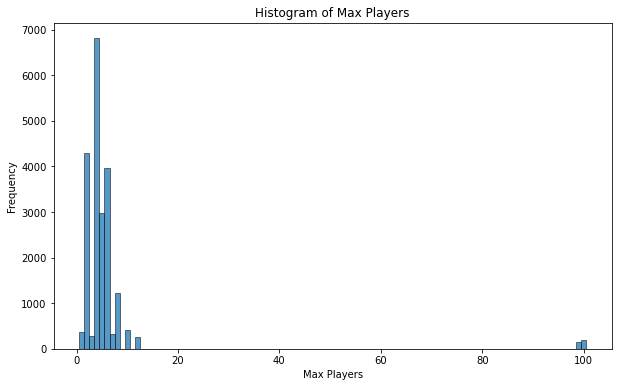

In [239]:
plt.figure(figsize=(10, 6))
sns.histplot(df['max_players'], discrete=True, kde=False)
plt.title('Histogram of Max Players')
plt.xlabel('Max Players')
plt.ylabel('Frequency')
plt.show()

Data for max_players look better, however we cannot forget about data scalling before building models.

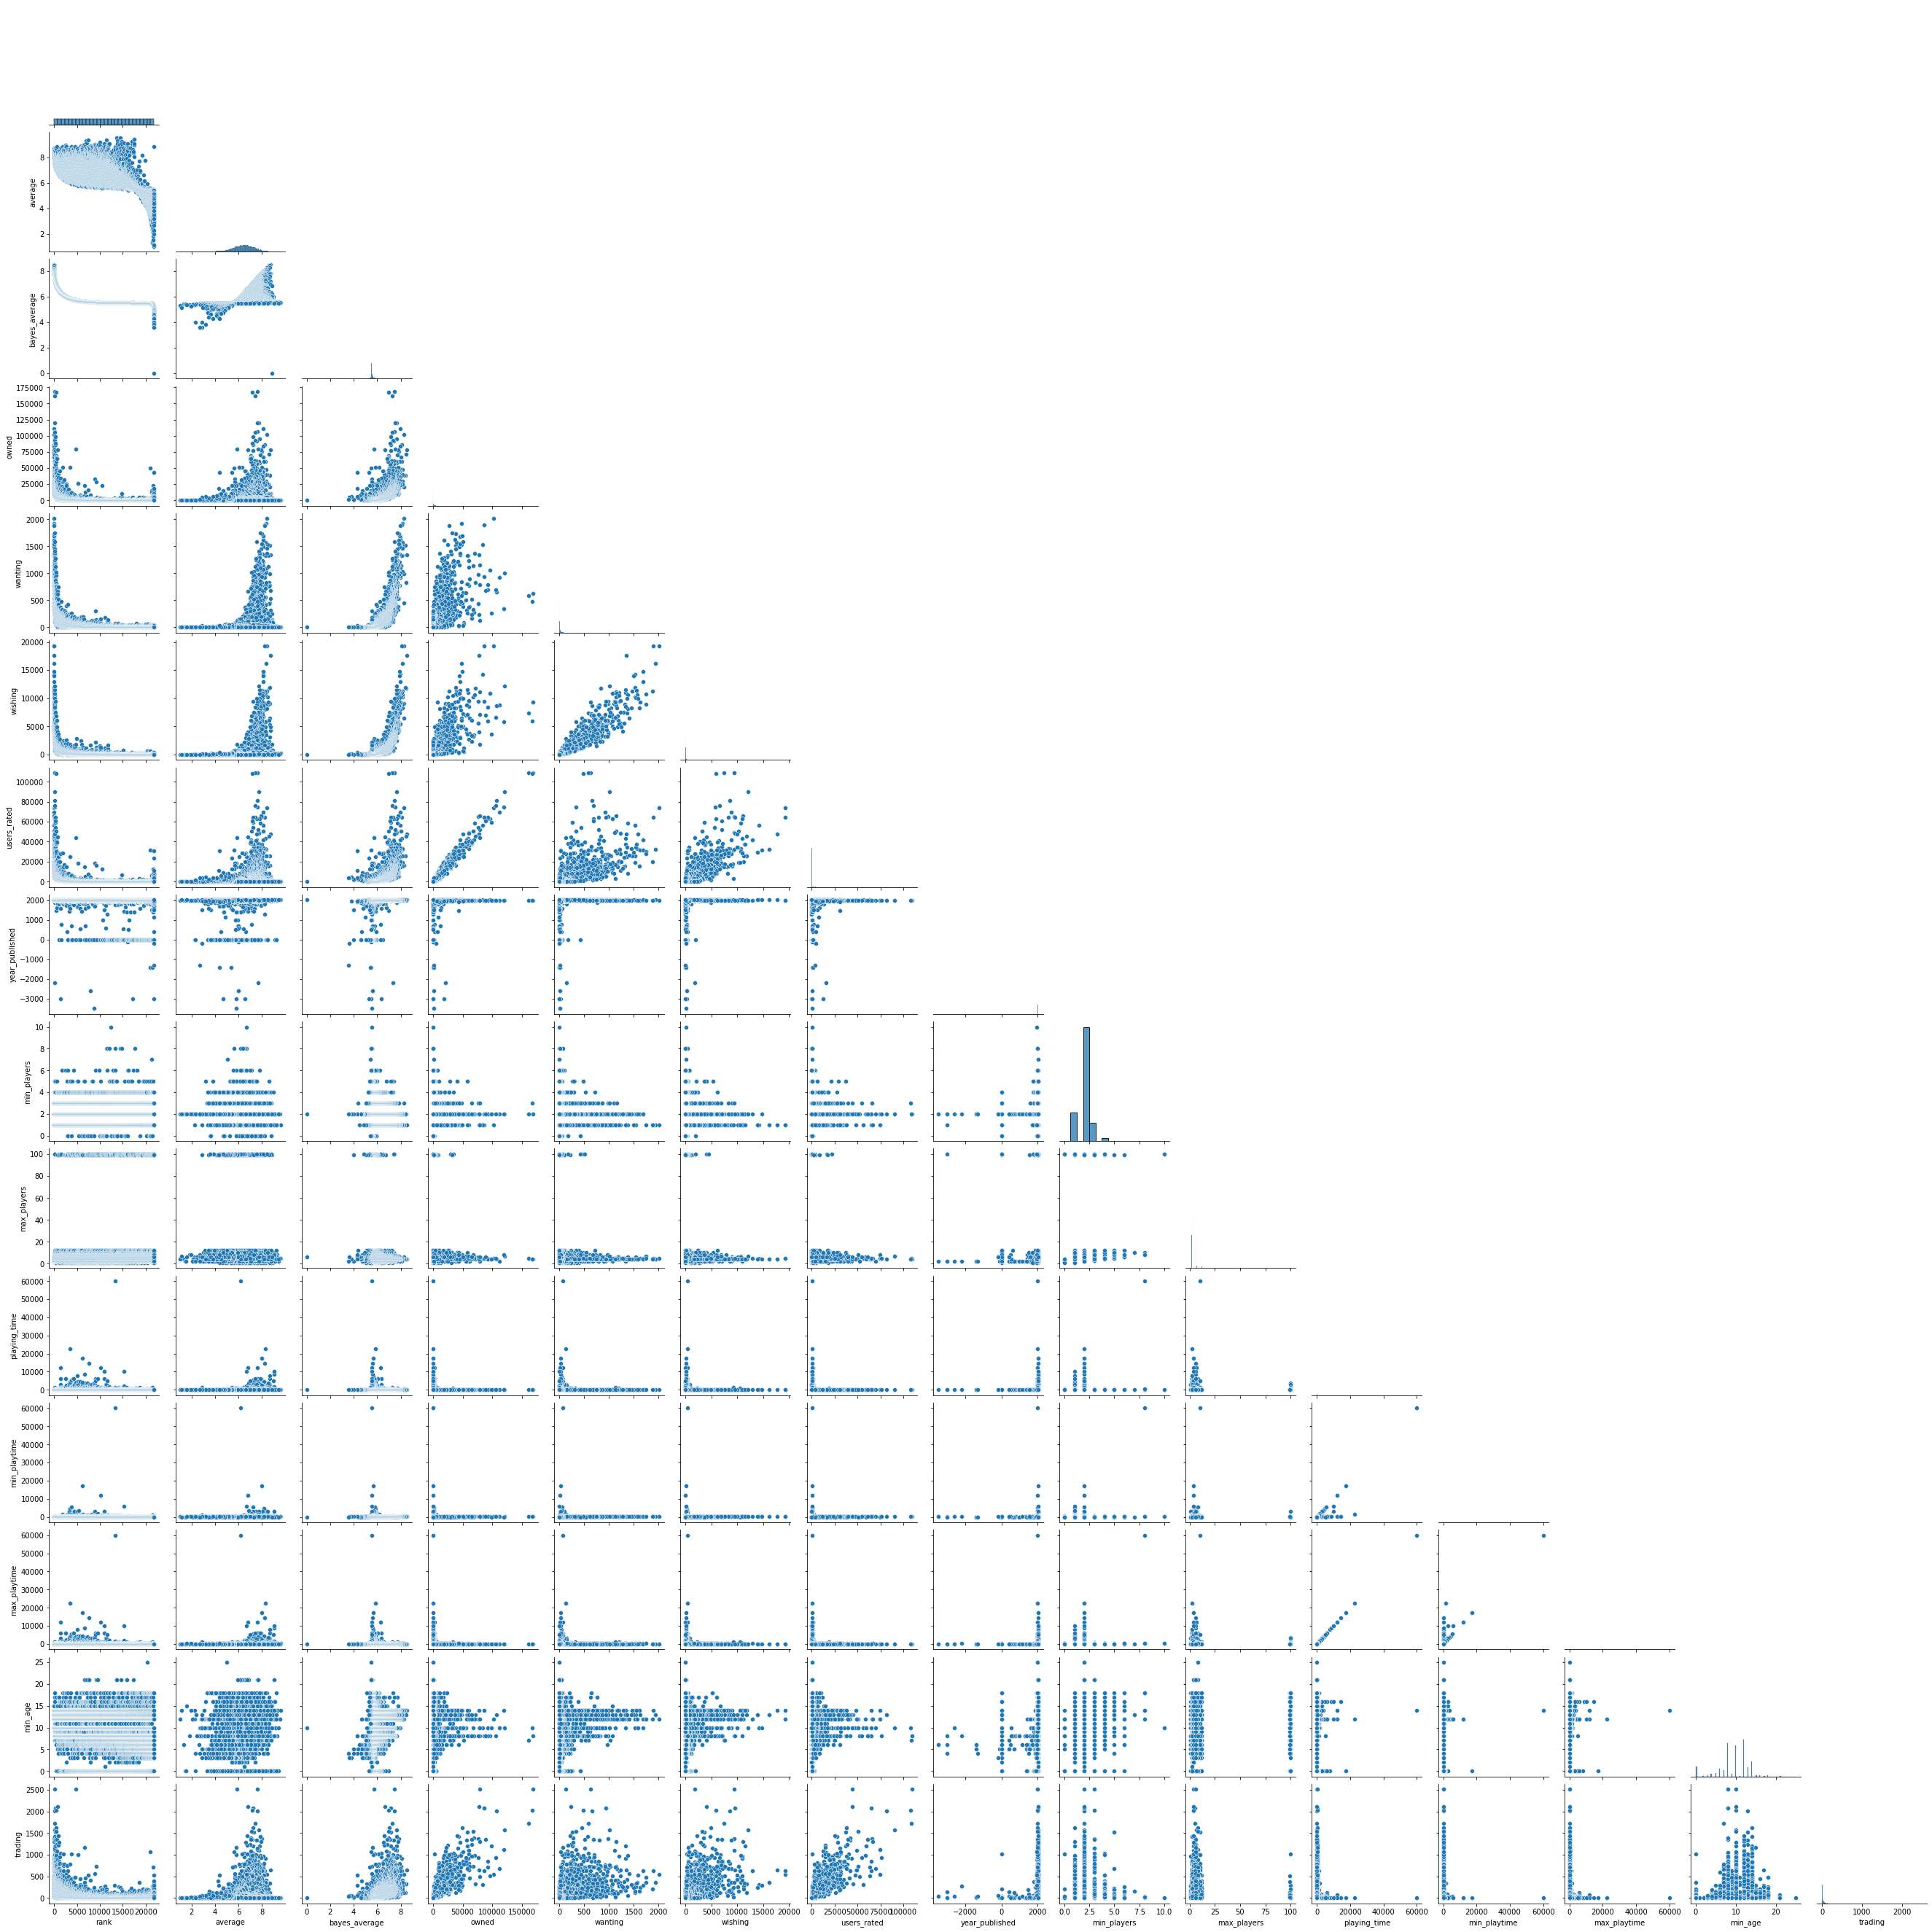

In [270]:
sns.pairplot(df, corner=True);

In [241]:
# Above chart is too small, let's focus on groups of variables
# players_cols = [col for col in df.columns if "players" in col]
users_cols = ["owned", "wanting", "wishing", "trading"]
rates_cols = ["average", "bayes_average", "users_rated"]

# Combine each list with 'rank' into a single DataFrame
players_df = pd.concat([df[['rank']], df[players_cols]], axis=1)
users_df = pd.concat([df[['rank']], df[users_cols]], axis=1)
rates_df = pd.concat([df[['rank']], df[rates_cols]], axis=1)

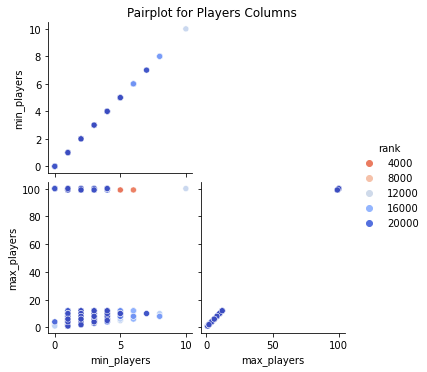

In [242]:
# Create pair plots combined with 'rank' for each list
sns.pairplot(players_df, hue='rank', corner=True, diag_kind =None, palette='coolwarm_r')
plt.suptitle('Pairplot for Players Columns', y=1.02)
plt.show()

Seems that best games are ment to be for max 5-6 players.

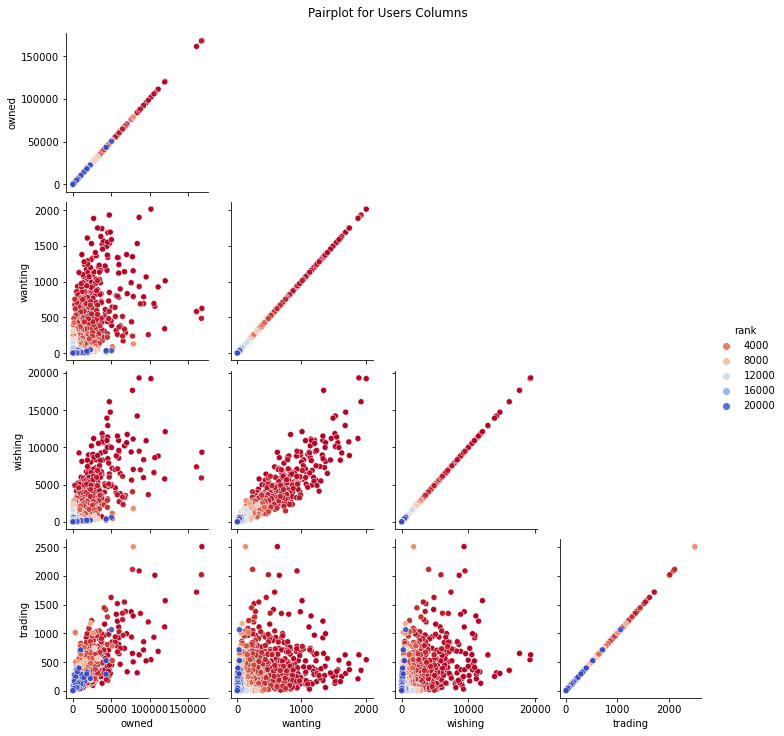

In [243]:
sns.pairplot(users_df, hue='rank', corner=True, diag_kind =None, palette='coolwarm_r')
plt.suptitle('Pairplot for Users Columns', y=1.02)
plt.show()

The lower rank (better game), the more people own these games. This observation is even stronger visible by number or people wanting and wishing low ranked games.

On the other hand, worse ranked games are beeing offered for trade more often, which is quite understandable - nobody likes to waste time for bad games.

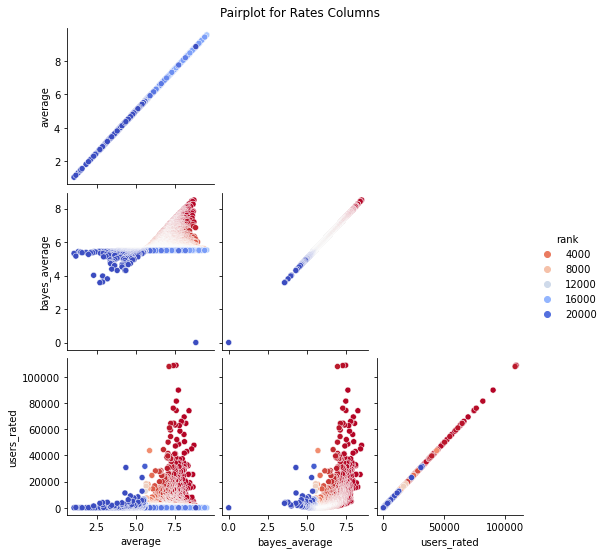

In [244]:
sns.pairplot(rates_df, hue='rank', corner=True, diag_kind =None, palette='coolwarm_r')
plt.suptitle('Pairplot for Rates Columns', y=1.02)
# plt.subplots_adjust(top=0.9)
plt.show()

Games with better (lower) rank are more often beeing rated and the rate is more diverged and rather positie - 5+ out of 10.

Games with further places in rank, are more likely to be rated below 5 points. We can clearly tell that user's rate may play a great role in rank position, but is not the only factor.

### Correlation heatmap

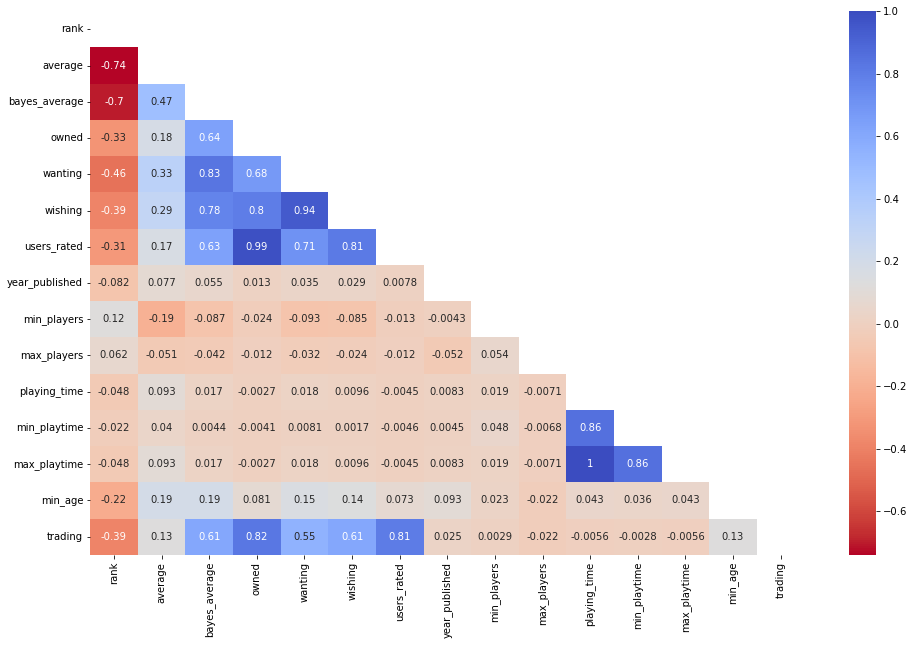

In [245]:
corr = df.corr()
matrix = np.triu(corr)
plt.figure(figsize=(16,10))

# using the upper triangle matrix as mask 
sns.heatmap(corr, annot=True, mask=matrix, cmap="coolwarm_r")
plt.show()

Correlation between rank and other variables is negative. That means: the higher numbers get, the lower rank is - meaning that game should be considered as "good".

# Model selection

## Preparing the variables and labels

In [255]:
data_only_numeric_cols = df.select_dtypes(include=['float64','int64'])
X = data_only_numeric_cols.drop(['rank'] , axis=1)
y = df['rank']

In [256]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Data scaling

In [257]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Hyperparameter tuning

In [258]:
# Linear Regression
lr_model = LinearRegression()
lr_param_grid = {}  # No hyperparameters to tune for Linear Regression

# Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42)
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Support Vector Machine Regressor
svm_model = SVR()
svm_param_grid = {
    'C': [0.1, 1.0, 10.0],
    'epsilon': [0.1, 0.01, 0.001],
    'kernel': ['linear', 'rbf']
}

### GridSearchCV for each model

In [259]:
lr_grid_search = GridSearchCV(lr_model, lr_param_grid, cv=5, scoring='neg_mean_squared_error')
lr_grid_search.fit(X_train_scaled, y_train)

# Save the trained GridSearchCV object to a file (after fitting the GridSearch)
with open('Models/lr_grid_search.pkl', 'wb') as file:
    pickle.dump(lr_grid_search, file)

In [260]:
rf_grid_search = GridSearchCV(rf_model, rf_param_grid, cv=5, scoring='neg_mean_squared_error')
rf_grid_search.fit(X_train_scaled, y_train)

# Save the trained GridSearchCV object to a file (after fitting the GridSearch)
with open('Models/rf_grid_search.pkl', 'wb') as file:
    pickle.dump(rf_grid_search, file)

In [261]:
svm_grid_search = GridSearchCV(svm_model, svm_param_grid, cv=5, scoring='neg_mean_squared_error')
svm_grid_search.fit(X_train_scaled, y_train)

# Save the trained GridSearchCV object to a file (after fitting the GridSearch)
with open('Models/svm_grid_search.pkl', 'wb') as file:
    pickle.dump(svm_grid_search, file)

In [262]:
# No parameteres for Linear Regression
print("Best params for Linear Regression:\n", lr_grid_search.best_params_)

Best params for Linear Regression:
 {}


In [263]:
print("Best params for Random Forest:\n", rf_grid_search.best_params_)

Best params for Random Forest:
 {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}


In [264]:
print("Best params for SVM:\n", svm_grid_search.best_params_)

Best params for SVM:
 {'C': 10.0, 'epsilon': 0.1, 'kernel': 'rbf'}


In [265]:
# Making predictions
lr_predictions = lr_grid_search.predict(X_test_scaled)
rf_predictions = rf_grid_search.predict(X_test_scaled)
svm_predictions = svm_grid_search.predict(X_test_scaled)

# Calculating RMSE (Root Mean Squared Error) for evaluation
lr_rmse = mean_squared_error(y_test, lr_predictions, squared=False)
rf_rmse = mean_squared_error(y_test, rf_predictions, squared=False)
svm_rmse = mean_squared_error(y_test, svm_predictions, squared=False)

lr_r2 = r2_score(y_test, lr_predictions)
rf_r2 = r2_score(y_test, rf_predictions)
svm_r2 = r2_score(y_test, svm_predictions)

print(f"Linear Regression RMSE: {lr_rmse:.3f}; R2: {lr_r2:.3f}")
print(f"Random Forest RMSE: {rf_rmse:.3f}; R2: {rf_r2:.3f}")
print(f"SVM RMSE: {svm_rmse:.3f}; R2: {svm_r2:.3f}")

Linear Regression RMSE: 3108.940; R2: 0.753
Random Forest RMSE: 30.428; R2: 1.000
SVM RMSE: 3056.833; R2: 0.761


## Final models

In [266]:
model_lr = LinearRegression()

In [267]:
model_rf = RandomForestRegressor(random_state=42,
                                 max_depth= 10,
                                 min_samples_leaf= 4,
                                 min_samples_split= 2,
                                 n_estimators= 300)

In [268]:
model_svm = SVR(C=10.0,
                epsilon=0.1,
                kernel='rbf')

In [269]:
def model_scores(model_name, model):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    MSE = mean_squared_error(y_test, y_pred)
    R2 = r2_score(y_test, y_pred)
    
    print(f"Results for {model_name}:")
    print(f"Mean Squared Error: {MSE:.3f}")
    print(f"R-squared:  {R2:.3f} \n")



models_dict = {"Linear Regression": model_lr,
         "Random Forest": model_rf,
         "SVM": model_svm}

for model_name, model in models_dict.items():
    scores = model_scores(model_name, model)


Results for Linear Regression:
Mean Squared Error: 9665509.979
R-squared:  0.753 

Results for Random Forest:
Mean Squared Error: 923.820
R-squared:  1.000 

Results for SVM:
Mean Squared Error: 9344229.290
R-squared:  0.761 



# Commentary

For given dataset, out of 3 tested models, best works random forest. Mean squared error is 923 which means the model is estimating the **rank** wrong by approximately 30 places.

Linear regression, does not work well with this dataset, as there is no linear trend. Support Vector Machines also does not make a good fit into solving this kind of problem.

In my opinion it is a good result, because there are lots of factors that are hard to model, but have strong influence on the board game's rating performance, such as marketing strategy and viral trends.

Further steps of this project could be to check how do games categories, mechanics, designers, artists and publishers influence on finall rank.